In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [2]:
#file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
file_path = '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp'
diagType1 = 'ocean_cobalt_omip_2d'
diagType2 = 'ocean_monthly'

# yearmons = ['047601-048012', '048101-048512', '048601-049012', '049101-049512', '049601-050012']
yearmons = ['052101-052512','052601-053012']
years = ['0521-0525','0526-0530']

In [3]:
plot_out='../plots_esm42/060922/esm42_dev_060922_'

In [4]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
dpco2_var = 'dpco2'
dpco2_file_prefix = os.path.join(file_path, diagType1, 'ts', 'monthly', '5yr/')
dpco2_files = [dot.join([dpco2_file_prefix + diagType1, ym, dpco2_var, 'nc']) for ym in yearmons]
# print(dpco2_files)

spco2_var = 'spco2'
spco2_file_prefix = os.path.join(file_path, diagType1, 'ts', 'monthly', '5yr/')
spco2_files = [dot.join([spco2_file_prefix + diagType1, ym, spco2_var, 'nc']) for ym in yearmons]
# print(spco2_files)

tos_var = 'tos'
tos_file_prefix = os.path.join(file_path, diagType2, 'ts', 'monthly', '5yr/')
tos_files = [dot.join([tos_file_prefix + diagType2, ym, tos_var, 'nc']) for ym in yearmons]
# print(tos_files)

In [5]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

## Models

In [6]:
#dpco2
ds_dpco2 = xr.open_mfdataset(dpco2_files, combine='by_coords')

#spco2
ds_spco2 = xr.open_mfdataset(spco2_files, combine='by_coords')

#tos
ds_tos = xr.open_mfdataset(tos_files, combine='by_coords')

In [7]:
# convert from Pascals to microatmospheres for easier comparison with ppm
# 1 atm = 1.01325 x 10^5 Pa; 1 microAtm = 0.101325 Pa; 
ds_spco2['spco2'].values = ds_spco2['spco2'].values * 1e6/1.0133e5
ds_spco2.spco2.attrs['units'] = 'micro-atm'

ds_dpco2['dpco2'].values = ds_dpco2['dpco2'].values * 1e6/1.0133e5
ds_dpco2.dpco2.attrs['units'] = 'micro-atm'

In [8]:
# # select just 1992-2012 dates
# import cftime

# ds_dpco2=ds_dpco2.sel(time=slice(cftime.DatetimeNoLeap(1992, 1, 1, 0, 0, 0, 0),cftime.DatetimeNoLeap(2012, 12, 31, 0, 0, 0, 0)))
# ds_spco2=ds_spco2.sel(time=slice(cftime.DatetimeNoLeap(1992, 1, 1, 0, 0, 0, 0),cftime.DatetimeNoLeap(2012, 12, 31, 0, 0, 0, 0)))
# ds_tos=ds_tos.sel(time=slice(cftime.DatetimeNoLeap(1992, 1, 1, 0, 0, 0, 0),cftime.DatetimeNoLeap(2012, 12, 31, 0, 0, 0, 0)))

# print('Selected times are between '+ str(min(ds_dpco2.time.values)) + ' and ' + str(max(ds_dpco2.time.values)))

In [9]:
# create climatologies
ds_dpco2_clim = ds_dpco2.groupby('time.month').mean(dim='time')
ds_spco2_clim = ds_spco2.groupby('time.month').mean(dim='time')
ds_tos_clim = ds_tos.groupby('time.month').mean(dim='time')

## Observations

In [10]:
# Surface pCO2 observations
# From Landschutzer et al. units are in micro-atmopheres, do not convert
spco2_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/spco2_smoothed_monthclim_landschutzer_1992to2012_esm4grid.nc'
spco2_obs = xr.open_dataset(spco2_obs_file)

# difference in pCO2 between seawater and air
# From Landschutzer et al. units are in micro-atmopheres, do not convert
dpco2_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/dco2_smoothed_monthclim_landschutzer_1992to2012_esm4grid.nc'
dpco2_obs = xr.open_dataset(dpco2_obs_file)

# WOA temperatures
tos_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/temp_monthclim_woa_esm4grid.nc'
tos_obs = xr.open_dataset(tos_obs_file)

# Summer minus Winter pCO2 difference

In [11]:
# Stock et al. 2020 uses JFM for the (Northern Hemisphere) winter months, and JAS for the NH summer months, 
# in consideration of the lagged response of the ocean to the atmosphere. (Despite caption indicating DJF/JJA)
# We will standardize to DJF/JJA going forward, to maintain consistency with other analyses.
DJF=[11,0,1]
JJA=[5,6,7] 

In [12]:
# Model total difference
# calculate amplitude summer minus winter difference in pCO2
north_hem = ds_dpco2_clim.isel(month=JJA).mean(dim='month') - ds_dpco2_clim.isel(month=DJF).mean(dim='month')
south_hem = ds_dpco2_clim.isel(month=DJF).mean(dim='month') - ds_dpco2_clim.isel(month=JJA).mean(dim='month')
south_hem = south_hem.where(south_hem.yh < 0, drop=True)

ds_dpco2_diff_summer_minus_winter = north_hem.dpco2.values
ds_dpco2_diff_summer_minus_winter[0:len(south_hem.dpco2),:] = south_hem.dpco2.values

In [13]:
# Obs summer minus winter difference in pCO2
var='dco2_smoothed_monthclim_landschutzer_1992to2012'
# calculate amplitude summer minus winter difference in pCO2
north_hem = dpco2_obs.isel(time=JJA).mean(dim='time') - dpco2_obs.isel(time=DJF).mean(dim='time')
south_hem = dpco2_obs.isel(time=DJF).mean(dim='time') - dpco2_obs.isel(time=JJA).mean(dim='time')
south_hem = south_hem.where(south_hem.yh < 0, drop=True)

dpco2_obs_diff_summer_minus_winter = north_hem[var].values
dpco2_obs_diff_summer_minus_winter[0:len(south_hem[var]),:] = south_hem[var].values

### Thermal vs. non-thermal component

In [14]:
# Model SST
# calculate amplitude summer minus winter difference in SST
north_hem = ds_tos_clim.isel(month=JJA).mean(dim='month') - ds_tos_clim.isel(month=DJF).mean(dim='month')
south_hem = ds_tos_clim.isel(month=DJF).mean(dim='month') - ds_tos_clim.isel(month=JJA).mean(dim='month')
south_hem = south_hem.where(south_hem.yh < 0, drop=True)

ds_tos_diff_summer_minus_winter = north_hem.tos.values
ds_tos_diff_summer_minus_winter[0:len(south_hem.tos),:] = south_hem.tos.values

spco2_ann = ds_spco2_clim.spco2.mean(dim='month').values

# thermal vs. non-thermal component of difference
# following Takahashi et al. 2002
ds_dpco2_diff_from_temp = 0.0423*spco2_ann*ds_tos_diff_summer_minus_winter
ds_dpco2_diff_from_bio = ds_dpco2_diff_summer_minus_winter - ds_dpco2_diff_from_temp

In [15]:
# Obs summer minus winter in temperature
var='temp_monthclim_woa'
# calculate amplitude summer minus winter difference in pCO2
north_hem = tos_obs.isel(time=JJA).mean(dim='time') - tos_obs.isel(time=DJF).mean(dim='time')
south_hem = tos_obs.isel(time=DJF).mean(dim='time') - tos_obs.isel(time=JJA).mean(dim='time')
south_hem = south_hem.where(south_hem.yh < 0, drop=True)

tos_obs_diff_summer_minus_winter = north_hem[var].values
tos_obs_diff_summer_minus_winter[0:len(south_hem[var]),:] = south_hem[var].values

spco2_obs_ann = spco2_obs.spco2_smoothed_monthclim_landschutzer_1992to2012.mean(dim='time').values

# thermal vs. non-thermal component of difference from obs
dpco2_obs_diff_from_temp = 0.0423*spco2_obs_ann*tos_obs_diff_summer_minus_winter
dpco2_obs_diff_from_bio = dpco2_obs_diff_summer_minus_winter - dpco2_obs_diff_from_temp

# Evaluate Skill Metrics

In [16]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [17]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [18]:
# Annual means
X=ds_dpco2_clim.dpco2.mean(dim='month').stack(z=('xh','yh')).values
Y=dpco2_obs.dco2_smoothed_monthclim_landschutzer_1992to2012.mean(dim='time').stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_dpco2 = X[mask] - Y[mask]
res2_dpco2 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_dpco2 = stats.skew(res1_dpco2)
skew2_dpco2 = stats.skew(res2_dpco2)
res_dpco2 = res1_dpco2
r_dpco2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_dpco2 = rmse_diffs(res_dpco2)
bias_dpco2 = np.mean(res_dpco2)

In [19]:
# Summer minus winter difference
X=np.ravel(ds_dpco2_diff_summer_minus_winter)
Y=np.ravel(dpco2_obs_diff_summer_minus_winter)
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_diffdpco2 = X[mask] - Y[mask]
res2_diffdpco2 = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_diffdpco2 = stats.skew(res1_diffdpco2)
skew2_diffdpco2 = stats.skew(res2_diffdpco2)
res_diffdpco2 = res1_diffdpco2
r_diffdpco2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_diffdpco2 = rmse_diffs(res_diffdpco2)
bias_diffdpco2 = np.mean(res_diffdpco2)

In [20]:
# Summer minus winter difference - temperature dependent
X=np.ravel(ds_dpco2_diff_from_temp)
Y=np.ravel(dpco2_obs_diff_from_temp)
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_diffdpco2_temp = X[mask] - Y[mask]
res2_diffdpco2_temp = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_diffdpco2_temp = stats.skew(res1_diffdpco2_temp)
skew2_diffdpco2_temp = stats.skew(res2_diffdpco2_temp)
res_diffdpco2_temp = res1_diffdpco2_temp
r_diffdpco2_temp = stats.pearsonr(X[mask],Y[mask])[0]
rmse_diffdpco2_temp = rmse_diffs(res_diffdpco2_temp)
bias_diffdpco2_temp = np.mean(res_diffdpco2_temp)

In [21]:
# Summer minus winter difference - "biology"
X=np.ravel(ds_dpco2_diff_from_bio)
Y=np.ravel(dpco2_obs_diff_from_bio)
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_diffdpco2_bio = X[mask] - Y[mask]
res2_diffdpco2_bio = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_diffdpco2_bio = stats.skew(res1_diffdpco2_bio)
skew2_diffdpco2_bio = stats.skew(res2_diffdpco2_bio)
res_diffdpco2_bio = res1_diffdpco2_bio
r_diffdpco2_bio = stats.pearsonr(X[mask],Y[mask])[0]
rmse_diffdpco2_bio = rmse_diffs(res_diffdpco2_bio)
bias_diffdpco2_bio = np.mean(res_diffdpco2_bio)

# Plot

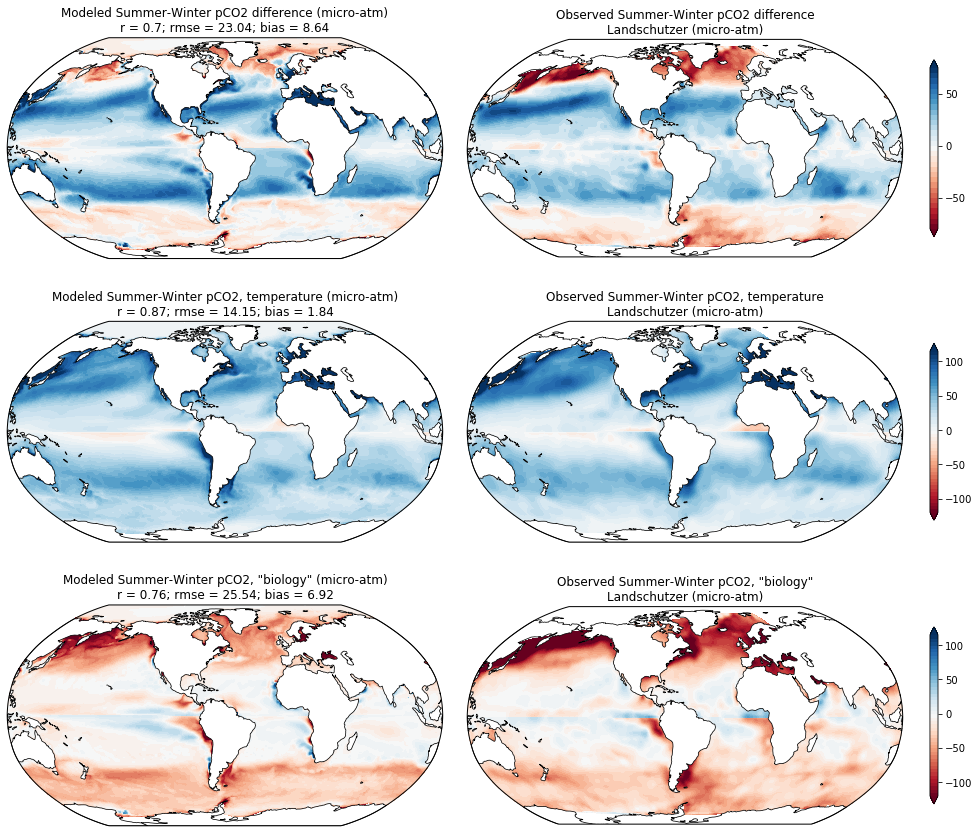

In [22]:
fig=plt.figure(figsize=(18,20))
gs=gridspec.GridSpec(4,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# dpco2 summer minus winter difference                                    #
###########################################################################
cmin=-80; cmax=80; cint=5
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_dpco2_diff_summer_minus_winter
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Summer-Winter pCO2 difference (micro-atm)\nr = ' + str(np.round(r_diffdpco2,2)) + \
                 '; rmse = ' + str(np.round(rmse_diffdpco2,2)) + \
                 '; bias = ' + str(np.round(bias_diffdpco2,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field=dpco2_obs_diff_summer_minus_winter
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Summer-Winter pCO2 difference\nLandschutzer (micro-atm)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-50,0,50], shrink=0.75)

###########################################################################
# dpco2 summer minus winter difference due to temperature                 #
###########################################################################
cmin = -120; cmax = 120; cint=5
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_dpco2_diff_from_temp
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Summer-Winter pCO2, temperature (micro-atm)\nr = ' + str(np.round(r_diffdpco2_temp,2)) + \
                 '; rmse = ' + str(np.round(rmse_diffdpco2_temp,2)) + \
                 '; bias = ' + str(np.round(bias_diffdpco2_temp,2)), fontsize=fs)

i=3
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field=dpco2_obs_diff_from_temp
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Summer-Winter pCO2, temperature\nLandschutzer (micro-atm)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-100,-50,0,50,100], shrink=0.75)

###########################################################################
# dpco2 summer minus winter difference due to "biology"                   #
###########################################################################

cmin = -120; cmax = 120; cint=5
levels=np.arange(cmin,cmax,cint)

i=4
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Robinson(central_longitude=300.0))
field1=ds_dpco2_diff_from_bio
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field1, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Summer-Winter pCO2, "biology" (micro-atm)\nr = ' + str(np.round(r_diffdpco2_bio,2)) + \
                 '; rmse = ' + str(np.round(rmse_diffdpco2_bio,2)) + \
                 '; bias = ' + str(np.round(bias_diffdpco2_bio,2)), fontsize=fs)

i=5
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Robinson(central_longitude=300.0))
field2=dpco2_obs_diff_from_bio
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field2, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Summer-Winter pCO2, "biology"\nLandschutzer (micro-atm)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-100,-50,0,50,100], shrink=0.75)


plt.tight_layout()
fname = 'CO2seasonal'
plt.savefig(plot_out+fname+'.png', dpi=300, bbox_inches='tight')